In [1]:
import geogridstore
import pvdeg

import numpy as np
import random
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import xarray as xr
import geogridstore.templates

In [ ]:
pointcount = 30
xmin, ymin, xmax, ymax = -109.059196,36.992751,-102.042126,41.00198

xext = xmax - xmin
yext = ymax - ymin

# Generate random points within the bounds of americas_box
points = []
while len(points) < pointcount:
    x = xmin + random.random() * xext
    y = ymin + random.random() * yext
    points.append ( Point(x, y) )

gs = gpd.GeoSeries(points, crs="EPSG:4326")  # Assuming WGS84 for input


lambert_proj = ccrs.LambertConformal(central_longitude=-105, central_latitude=39.5)
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={"projection": lambert_proj})
ax.set_extent([-120, -90, 30, 50], crs=ccrs.PlateCarree())  # Broader bounds for zoomed-out view
ax.coastlines()  # Add coastlines for reference
for point in gs.geometry:
    ax.plot(point.x, point.y, 'ro', transform=ccrs.PlateCarree())  # Transform to Lambert
plt.title("Random Points in Lambert Conformal Projection (Zoomed-Out View)")
plt.show()

# ortho_proj = ccrs.Orthographic(central_longitude=-105, central_latitude=39.5)
# # Plot using Cartopy
# fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ortho_proj})
# # Set extent to focus on the region of interest
# ax.set_global()  # Orthographic automatically focuses on the globe, no need for extent
# ax.coastlines()  # Add coastlines for reference
# ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
# # Plot the points in Orthographic projection
# for point in gs.geometry:
#     ax.plot(point.x, point.y, 'rx', transform=ccrs.PlateCarree())  # Transform to Orthographic
# plt.title("Random Points in Orthographic Projection (Centered on Colorado)")

These grid indexes refer to the elements in the reference pre-baked grid. We have effectively "re-mapped" our gids and can now assign points to these values as they are meaningful. This can produce duplicates which is slightly problematic.

In [ ]:
client = pvdeg.geospatial.start_dask()

In [ ]:
# we will collect weather data for these points
# we need to pass a list of tuples not a numpy array
tuple_coords = [tuple(coord) for coord in np.column_stack((gs.y, gs.x))]

weather, meta, failed = pvdeg.weather.weather_distributed(
    database="PVGIS",
    coords=tuple_coords,
)

### Saving

Now that we have weather data, we want to save it to disk. We can do this using the top level `store` function. We must provide a path to an existing store.

In [ ]:
comb = pvdeg.store._combine_geo_weather_meta(weather, meta)
comb

In [ ]:
geogridstore.store(
    dataset=comb,
    store=geogridstore.pvgis_tmy,
    grid_points_fn="4km-points.npz"
)

In [2]:
loaded = xr.open_zarr(store=geogridstore.pvgis_tmy.path)
lw, lm = pvdeg.store._seperate_geo_weather_meta(loaded)

# potentially problematic, the metadata gids are floats, not ints

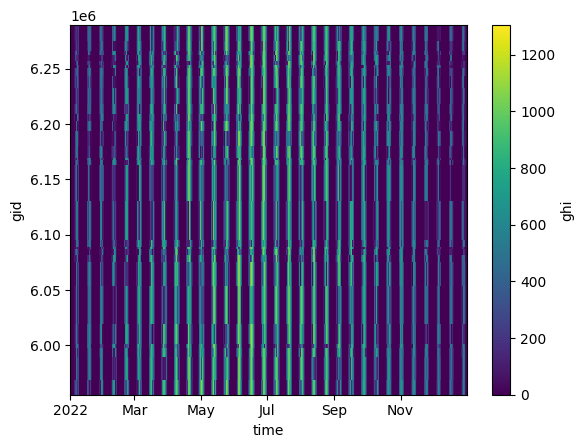

In [3]:
lw.ghi.plot()

In [4]:
pvdeg.spectral.solar_position(
    lw.isel(gid=0).to_dataframe(),
    lm.iloc[0].to_dict(),
)

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
time,,,,,,
2022-01-01 00:00:00,89.311285,89.651245,0.688715,0.348755,240.174879,-3.297910
2022-01-01 01:00:00,100.390627,100.390627,-10.390627,-10.390627,248.879784,-3.317689
2022-01-01 02:00:00,111.760332,111.760332,-21.760332,-21.760332,257.027727,-3.337460
2022-01-01 03:00:00,123.507510,123.507510,-33.507510,-33.507510,265.220048,-3.357223
2022-01-01 04:00:00,135.395541,135.395541,-45.395541,-45.395541,274.339018,-3.376976
...,...,...,...,...,...,...
2022-12-31 19:00:00,60.639745,60.663073,29.360255,29.336927,175.295977,-3.088616
2022-12-31 20:00:00,61.298500,61.322460,28.701500,28.677540,191.059739,-3.108391
2022-12-31 21:00:00,65.079908,65.108067,24.920092,24.891933,205.929313,-3.128158
